# Third attempt at preferential attachment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import random

G = pickle.load(open('data/ai_ecosystem_graph_finetune.pkl', 'rb'))

ModuleNotFoundError: No module named 'pandas'

In [2]:
import numpy as np
import networkx as nx
from collections import defaultdict

# ---------- tiny utilities ----------
def ymd(s):
    """Fast: extract 'YYYY-MM-DD' from an ISO string; return None if missing."""
    return s[:10] if (isinstance(s, str) and len(s) >= 10) else None

def build_log2_bins(max_k):
    """[(0,0),(1,1),(2,3),(4,7),...] covering up to max_k (inclusive)."""
    if max_k <= 0:
        return [(0,0)]
    bins = [(0,0), (1,1)]
    lo, hi = 2, 3
    while hi < max_k:
        bins.append((lo, hi))
        lo, hi = hi + 1, 2*hi + 1
    if bins[-1][1] < max_k:
        bins.append((lo, max_k))
    return bins

def bin_index(k, bins):
    """Binary search inclusive bins."""
    lo, hi = 0, len(bins)-1
    while lo <= hi:
        m = (lo+hi)//2
        a,b = bins[m]
        if k < a: hi = m-1
        elif k > b: lo = m+1
        else: return m
    return None  # should not happen if bins cover k

# ---------- main estimator ----------
def estimate_pa_kernel_scaled(
    G: nx.DiGraph,
    start_ymd: str = "2023-01-01",
    end_ymd: str   = "2023-12-31",
    k0: float = 1.0,            # offset for k=0 stability
    use_log_bins: bool = True,  # log bins for speed/stability
    verbose: bool = True
):
    """
    Scalable exposure–event estimator for the preferential-attachment kernel on a time-stamped lineage tree.
    Complexity: one pass over nodes, one pass over edges, sort events, one linear sweep over events.
    Returns:
      {
        'alpha': float,
        'fit': {'alpha':..,'intercept':..,'r2_loglog':..},
        'summary': list of dict rows (bin_lo, bin_hi, k_rep, N_exposure, M_choices, Ahat),
        'bins': [(lo,hi),...],
        'k0': k0,
        'counts': {'num_events':E,'eligible_at_start':n_elig}
      }
    """

    assert isinstance(G, nx.DiGraph), "Expect parent->child DiGraph."

    # 1) createdAt -> 'YYYY-MM-DD' (fast) and eligible count at start
    created = {}
    n_elig = 0
    for n, t in G.nodes(data="createdAt", default=None):
        d = ymd(t)
        created[n] = d
        if d is not None and d < start_ymd:
            n_elig += 1

    # 2) Single edge pass:
    #    - pre_start_k[parent] = #children with child_ymd < start_ymd
    #    - events = [(child_ymd, parent), ...] for start <= child_ymd <= end and parent_ymd < child_ymd
    pre_start_k = defaultdict(int)
    events = []  # (date_str, parent)
    get = created.get
    for u, v in G.edges():
        tv = get(v)  # child date
        if tv is None:
            continue
        tu = get(u)  # parent date
        if tu is None or not (tu < tv):
            continue  # malformed or time-inconsistent
        if tv < start_ymd:
            pre_start_k[u] += 1
        elif start_ymd <= tv <= end_ymd:
            events.append((tv, u))

    # Sort events chronologically (string sort is correct on 'YYYY-MM-DD')
    events.sort(key=lambda x: x[0])
    E = len(events)
    if verbose:
        print(f"[init] eligible_at_start={n_elig:,d}, events_in_window={E:,d}, parents_with_prestart_children={len(pre_start_k):,d}")

    # 3) Initial histogram H over ALL eligible nodes at window start
    #    For k>=1: count via pre_start_k; For k=0: H0 = n_elig - sum_{k>=1} count_k
    degree_counts = defaultdict(int)
    max_k0 = 0
    for _, k in pre_start_k.items():
        degree_counts[k] += 1
        if k > max_k0: max_k0 = k

    if use_log_bins:
        bins = build_log2_bins(max_k0)
        H = np.zeros(len(bins), dtype=np.int64)
        # fill k>=1
        for k, c in degree_counts.items():
            bi = bin_index(k, bins)
            H[bi] += c
        # zero-degree bucket
        H0 = n_elig - int(sum(degree_counts.values()))
        # ensure [0,0] bin exists at index 0
        H[bin_index(0, bins)] += H0
        # exposure and choice vectors
        Nexp = np.zeros_like(H)
        Mch  = np.zeros_like(H)

        def ensure_cover(k_needed):
            nonlocal bins, H, Nexp, Mch
            if k_needed <= bins[-1][1]:
                return
            # extend bins until they cover k_needed
            lo = bins[-1][1] + 1
            hi = 2*bins[-1][1] + 1
            while hi < k_needed:
                bins.append((lo, hi))
                lo, hi = hi + 1, 2*hi + 1
            bins.append((lo, k_needed))
            # pad hist arrays
            pad = len(bins) - len(H)
            if pad > 0:
                H    = np.pad(H,    (0, pad))
                Nexp = np.pad(Nexp, (0, pad))
                Mch  = np.pad(Mch,  (0, pad))
    else:
        # Exact per-degree histogram (use if the number of distinct degrees is small)
        bins = None
        H = defaultdict(int)
        for k, c in degree_counts.items():
            H[k] += c
        H0 = n_elig - int(sum(degree_counts.values()))
        H[0] += H0
        Nexp = defaultdict(int)
        Mch  = defaultdict(int)

    # Current degree for parents that get chosen during the window
    curr_deg = {}  # parent -> k at current time
    # Pre-fill for parents that already have k>0 before start (saves 1 dict hit on first use)
    for p, k in pre_start_k.items():
        curr_deg[p] = k

    # 4) Sweep events
    #    At each event:
    #       Nexp += H
    #       k = curr_deg.get(p, 0); Mch[bin(k)] += 1; move H: k->k+1
    #       Add the newborn child to degree-0 bucket: H[0] += 1
    #    (We do not need child id; every event adds exactly one new eligible node.)
    for tstr, p in events:
        # exposures before choosing a parent
        if use_log_bins:
            Nexp += H
        else:
            for k, c in H.items():
                Nexp[k] += c

        k = curr_deg.get(p, 0)

        if use_log_bins:
            # ensure bins cover k+1, then update counts
            ensure_cover(k+1)
            bi_k  = bin_index(k,   bins)
            bi_k1 = bin_index(k+1, bins)
            Mch[bi_k] += 1
            H[bi_k]   -= 1
            H[bi_k1]  += 1
        else:
            Mch[k]  += 1
            H[k]    -= 1
            H[k+1]  += 1

        curr_deg[p] = k + 1

        # newborn child becomes eligible at degree 0 for future events
        if use_log_bins:
            H[bin_index(0, bins)] += 1
        else:
            H[0] += 1

    # 5) Summarize and fit alpha on log–log: log Ahat = c + alpha * log(k+k0)
    eps = 1e-12
    summary = []
    if use_log_bins:
        for (lo, hi), Nj, Mj in zip(bins, Nexp, Mch):
            if Nj == 0 and Mj == 0: 
                continue
            # bin representative degree
            krep = lo if lo == hi else (np.sqrt(lo*hi) if lo > 0 else (lo + hi) / 2.0)
            Ahat = (Mj + eps) / (Nj + eps)
            summary.append({
                "bin_lo": lo, "bin_hi": hi, "k_rep": float(krep),
                "N_exposure": int(Nj), "M_choices": int(Mj), "Ahat": float(Ahat)
            })
    else:
        for k in sorted(Nexp.keys()):
            Nj = Nexp[k]; Mj = Mch.get(k, 0)
            if Nj == 0 and Mj == 0:
                continue
            Ahat = (Mj + eps) / (Nj + eps)
            summary.append({
                "bin_lo": k, "bin_hi": k, "k_rep": float(k),
                "N_exposure": int(Nj), "M_choices": int(Mj), "Ahat": float(Ahat)
            })

    if not summary:
        raise ValueError("No events/exposures in the specified window.")

    # Weighted least squares with weights ~ choices (stable in sparse high-k)
    x = np.log(np.array([row["k_rep"] for row in summary]) + k0)
    y = np.log(np.array([row["Ahat"]  for row in summary]))
    w = np.maximum(1.0, np.array([row["M_choices"] for row in summary], dtype=float))
    # y = a*x + b
    coeffs = np.polyfit(x, y, deg=1, w=w)
    alpha, intercept = float(coeffs[0]), float(coeffs[1])
    yhat = alpha * x + intercept
    wmean = np.average(y, weights=w)
    ss_tot = np.sum(w * (y - wmean)**2)
    ss_res = np.sum(w * (y - yhat)**2)
    r2 = float(1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan))

    if verbose:
        print(f"[fit] alpha={alpha:.3f}, R^2(log–log)={r2:.3f}, k0={k0}")

    return {
        "alpha": alpha,
        "fit": {"alpha": alpha, "intercept": intercept, "r2_loglog": r2},
        "summary": summary,
        "bins": bins,
        "k0": k0,
        "counts": {"num_events": E, "eligible_at_start": n_elig}
    }


In [48]:
res = estimate_pa_kernel_scaled(
    G,
    start_ymd="2023-01-01",
    end_ymd="2024-12-31",
    k0=1,
    use_log_bins=False,
    verbose=True
)
print(res["fit"])

[init] eligible_at_start=101,187, events_in_window=105,000, parents_with_prestart_children=173
[fit] alpha=2.063, R^2(log–log)=0.320, k0=1
{'alpha': 2.0631757097212464, 'intercept': -13.87810342873999, 'r2_loglog': 0.3201602368155635}


/Users/benjaminlaufer/Python Projects/ai-preferential-attachment/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


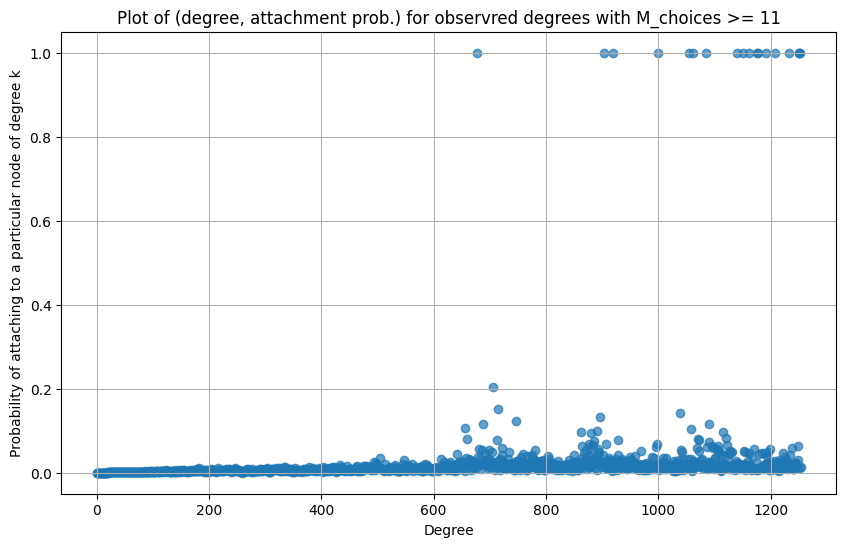

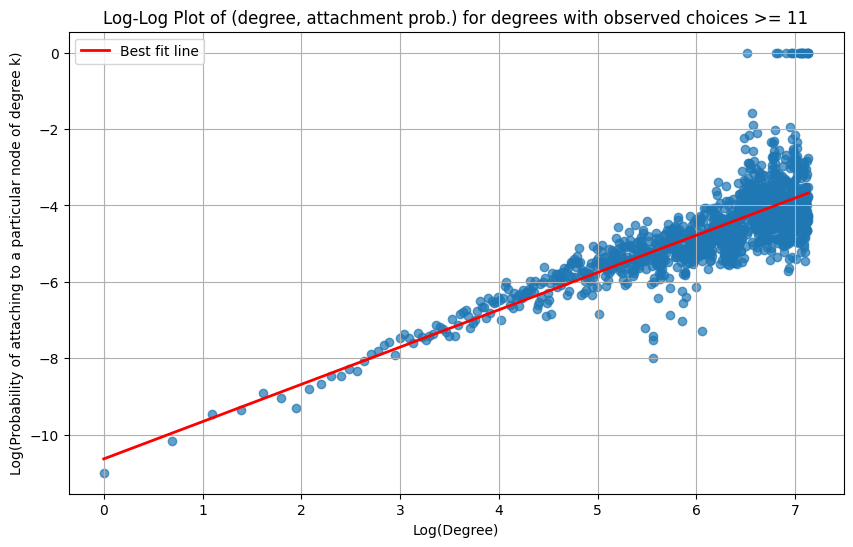

In [67]:
import matplotlib.pyplot as plt

# Create a filtered dataset where M_choices > 5
filtered_summary = pd.DataFrame(res['summary'])
filtered_summary = filtered_summary[filtered_summary['M_choices'] > 10]

# Plot (k_rep, Ahat) values
plt.figure(figsize=(10, 6))
plt.scatter(filtered_summary['k_rep'], filtered_summary['Ahat'], alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Probability of attaching to a particular node of degree k')
plt.title(f'Plot of (degree, attachment prob.) for observred degrees with M_choices >= {filtered_summary["M_choices"].min()}')
plt.grid(True)

# Plot the log-log fit
plt.figure(figsize=(10, 6))
plt.scatter(np.log(filtered_summary['k_rep']), np.log(filtered_summary['Ahat']), alpha=0.7)
plt.xlabel('Log(Degree)')
plt.ylabel('Log(Probability of attaching to a particular node of degree k)')
plt.title(f'Log-Log Plot of (degree, attachment prob.) for degrees with observed choices >= {filtered_summary["M_choices"].min()}')
plt.grid(True)

# Plot the line of best fit
# Calculate the best fit line for the log-log plot
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for linear regression
X = np.log(filtered_summary['k_rep']).values[1:].reshape(-1, 1)
y = np.log(filtered_summary['Ahat']).values[1:]

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the line of best fit
x_fit = np.linspace(X.min(), X.max(), 100)
y_fit = model.predict(x_fit.reshape(-1, 1))

# Plot the line of best fit
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Best fit line')
plt.legend()


plt.show()


In [64]:
print(len(X))
print(y)

1255
[-14.55107426 -11.00051903 -10.1713392  ...   0.          -4.41334911
  -4.32353043]


In [18]:
# Print all rows of the dataframe
pd.options.display.max_rows = 10000

pd.DataFrame(res['summary'])


,bin_lo,bin_hi,k_rep,N_exposure,M_choices,Ahat
0,0,0,0.0,2376373094,1715,7.216880e-07
1,1,1,1.0,13974691,816,5.839127e-05
2,2,2,2.0,4340274,527,1.214209e-04
3,3,3,3.0,1422533,424,2.980599e-04
4,4,4,4.0,1021596,348,3.406435e-04
5,5,5,5.0,599489,310,5.171071e-04
6,6,6,6.0,549840,265,4.819584e-04
7,7,7,7.0,355029,241,6.788178e-04
8,8,8,8.0,280131,221,7.889166e-04
9,9,9,9.0,297839,197,6.614312e-04


In [ ]:
# plot the 